In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### RNN Behaviors - Proof of concept

In this notebook, we will begin by defining a few functions that will be useful. After that, we will do some simple examples with random neural network as a proof of concept. After that, we will try with real data set.

Therefore, the plan is :
- Defining function to solve, plot, train and evaluate the quality of our neurons
- Examples with random matrix of different matrix
- Examples with real dataset
- Adding pVar

**Compute RNN**

In [2]:
def dydx(t,x,W, sigma, mu):
    '''Differential equation'''
    return -x + sigma(W @ x - mu)

def rnn(t, IC, dydx, W, sigma=lambda x: ((1+np.exp(-x))**(-1)), mu=0):
    '''Approximate RNN behaviors using RK4 numerical method
    -----------------------
    t : np.linspace()
        Time array
    IC : Line vector
        Initial condition
    dydx : Function
        Differential equation
    W : Matrix of shape (n_neuron x n_neuron)
        Weight matrix
    sigma : Function
        Activation function (sigmoid if unspecified)
    mu : float/int
        Activation threshold (0 if unspecified)
    ----------------------
    return result and dt
    '''
    n = len(IC)
    m = len(t)
    res = np.zeros((m, n))   #mxn matrix that contain our values
    res[0] = IC  # First line is redefine
    dt = (t[-1] - t[0])/m
    for i in range(1, m):
        k1 = dt * dydx(t[i-1], res[(i-1)], W=W, sigma=sigma, mu=mu)
        k2 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k1, W=W, sigma=sigma, mu=mu)
        k3 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k2, W=W, sigma=sigma, mu=mu)
        k4 = dt * dydx(t[i-1] + dt, res[(i-1)] + k3, W=W, sigma=sigma, mu=mu)
        res[i] = res[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6
    
    return res, dt

**Generate fake data for test**

In [3]:
def GenerateData(n_data, time, IC, W, ratio=0.6, mu=0, sigma=lambda x: (1+np.exp(-x))**(-1)):
    '''
    Generate fake data that follow a RNN function
    -------------------
    n_data : int
        Number of data per neuron
    time : float
        Time of our sample
    IC : Line 
        Initials conditions
    W : Square matrix with shape n_neurons x n_neurons
        Weight Matrix
    ratio : float or int ]0,1]
        Percentage of our fake data that will be use for training
    mu : float or int
        Activation threshold (0 if unspecified)
    sigma : function
        Non-linearities (sigmoid if unspecified)
    -------------------
    Return dict
    '''

    t = np.linspace(0, time, n_data)

    Slice = int(ratio * len(t))
    time_data = t[:Slice]
    Test_Data = np.array([])
    if ratio < 1:
        time_test = t[Slice:]
        Test_Data = rnn(t=time_test, IC=IC, dydx=dydx, W=W, sigma=sigma, mu=mu).T

    Data, dt = rnn(t=time_data, IC=IC, dydx=dydx, W=W, sigma=sigma, mu=mu)
    Data = Data.T

    out = {}
    out["Data"] = Data
    out["Test_Data"] = Test_Data
    out["W"] = W
    out["dt"] = dt
    out["mu"] = mu

    return out

### Training

We use the following equation to represent our behavior :

$\dot{\vec{x}} = -x+\sigma(Wx+\mu)$

With Euler, we have :

$x(t+\Delta t) = x(t) + \Delta x =  x(t)[1-\Delta t]+\sigma(Wx-\mu)\Delta t$

*New features*:
- Code has been vectorize
- STD of the random matrix has been decrease
- Momentum was added

In [4]:
class RNNModel(nn.Module):

    def __init__(self, W, dt, mu):
        super(RNNModel, self).__init__()
        self.W = W
        self.dt = dt
        self.mu = mu
    
    def forward(self, x):
        return x * (1-self.dt) + (torch.sigmoid(torch.matmul(self.W, x) - self.mu))*self.dt

In [51]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from Hessianfree import HessianFree


def Train_RNN(n_neurons, x, dt, mu, lr=1, n_iters=500, verbose=False, loss_graph=False):
    '''
    Function that train our RNN to match a specific model
    ----------------------
    n_neurons : int
        Number of neurons in our RNN
    x : Matrix (n_data x n_neurons) np.array or torch.tensor
        Activity of neuron with their time step
    dt : float/int
        Delta_t (Euler's discretisation)
    mu : int/float
        Activity threshold (same for true data and predicted)
    lr : int/float
        learning rate(1 if unspecified)
    n_iters : int
        number of iteration (epochs) (500 if unspecified)
    verbose : bool
        Update on epochs (False if unspecified)
    loss_graph : bool
        Plot loss function
    ----------------------
    return dict
    '''
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    #Set up
    #W = torch.zeros(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = 0.001*torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify
    
    model = RNNModel(W=W, dt=dt, mu=mu)
    #optimizer = HessianFree(model.parameters())
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    loss = nn.MSELoss()

    #x_pred = torch.zeros(x.shape[0], x.shape[1])

    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):
        #Forward pass
        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC

        x_pred_temp = model(x[:-1].T)
        #All of time step except the last one
        #With N time step, we never use x(t=N) 
        x_pred[1:] = x_pred_temp.T

        
        #Loss
        l = loss(x, x_pred)

        #Gradient
        l.backward()

        #if 4*epoch < n_iters:
        #    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8)
        #else:
        #    optimizer = torch.optim.SGD(model.parameters(), lr=4*lr, momentum=0.8)

        #update weight matrix
        optimizer.step()
        optimizer.zero_grad()

        if verbose:
            if (epoch+1) % 100 == 1:
                with torch.no_grad():
                    y = x.detach().numpy()
                    y_pred = x_pred.detach().numpy()
                    pVar = 1 - ((np.linalg.norm(y-y_pred))**2/(np.linalg.norm(y_pred - np.mean(y_pred, axis=0)))**2)
                
                print(f"epoch {epoch}/{n_iters} loss {l:.6f} pVar {pVar:.3f}")

        with torch.no_grad():
            Total_loss.append(l.numpy())

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = lr
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"
    out["params"]["loss"] = f"{loss}"


    if loss_graph:
        t = np.linspace(0, n_iters, len(Total_loss))
        plt.plot(t, Total_loss, "r-")
        plt.grid(True)
        plt.title(f"Loss function with lr = {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    return out


**Adaptive learning rate**

In [6]:
def learn_rate(epoch, a, b):
    #format a*np.exp(b*epoch)
    return a * np.exp(b * epoch)

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN_AdaptLR(n_neurons, x, dt, mu, n_iters=500, verbose=False, loss_graph=False, a=0.01, b=0.0055):
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    #Set up
    W = torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify

    Learning_rates = []
    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):

        model = RNNModel(W=W, dt=dt, mu=mu)
        lr = learn_rate(epoch, a, b)
        Learning_rates.append(lr)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        loss = nn.MSELoss()


        #Forward pass
        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC

        x_pred_temp = model(x[:-1].T)
        x_pred[1:] = x_pred_temp.T

        #Loss
        l = loss(x, x_pred)

        #Gradient
        l.backward()

        #update weight matrix
        optimizer.step()
        optimizer.zero_grad()

        if verbose:
            if (epoch+1) % 100 == 1:
                print(f"epoch {epoch}/{n_iters} loss {l:.6f}")

        with torch.no_grad():
            Total_loss.append(l.numpy())

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = Learning_rates
    out["params"]["loss"] = Total_loss
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"


    if loss_graph:
        plt.plot(Learning_rates, Total_loss, "r-")
        plt.xlabel("learning rate (log)")
        plt.ylabel("loss")
        plt.xscale("log")
        plt.title(f"learning rate when working with {n_neurons} neurons")
        plt.show()
    
    return out


**Quality**

The following code allows us to identify the neurons that cause problem in our train model

In [7]:
def quality(n_neuron, true, train, num_max=1):
    '''
    Plot and identify the quality of the training
    ---------------------
    n_neuron : int
        Number of neurons in our system
    true : ndarray
        True value of our model
    train : ndarray
        Train model
    num_max : int
        Number of neurons with the worst loss function
    '''
    MSE_total = []

    for i in range(n_neuron):
        MSE = np.mean((train[:,i] - true[:,i])**2)
        MSE_total.append(MSE)

    plt.plot(np.linspace(1, n_neuron, n_neuron), MSE_total, "-")
    plt.xlabel("neuron")
    plt.ylabel("loss")
    plt.show()

    worst = []

    for i, neuron in enumerate((sorted(MSE_total)[::-1])):
        if i < num_max:
            worst.append(MSE_total.index(neuron))

    return worst


**Examples**
---------------

Let's begin with the same example as CURBD. We will take $172$ neurons and $4000$ time step. However, we will use $2500$ time step rather than $40$. We have:

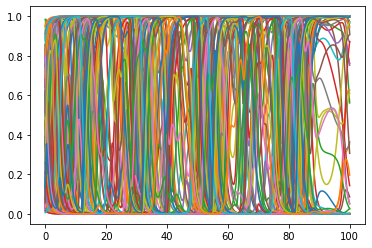

In [7]:
t = np.linspace(0, 100, 1000)
IC = np.random.rand(172)
W = 3*np.random.randn(172, 172)

data = GenerateData(n_data=4000, time=100, IC=IC, W=W , ratio=1)

plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0])
plt.show()

epoch 0/2500 loss 0.000147
epoch 100/2500 loss 0.000009
epoch 200/2500 loss 0.000006
epoch 300/2500 loss 0.000005
epoch 400/2500 loss 0.000004
epoch 500/2500 loss 0.000003
epoch 600/2500 loss 0.000003
epoch 700/2500 loss 0.000003
epoch 800/2500 loss 0.000003
epoch 900/2500 loss 0.000003
epoch 1000/2500 loss 0.000002
epoch 1100/2500 loss 0.000002
epoch 1200/2500 loss 0.000002
epoch 1300/2500 loss 0.000002
epoch 1400/2500 loss 0.000002
epoch 1500/2500 loss 0.000002
epoch 1600/2500 loss 0.000002
epoch 1700/2500 loss 0.000002
epoch 1800/2500 loss 0.000002
epoch 1900/2500 loss 0.000002
epoch 2000/2500 loss 0.000002
epoch 2100/2500 loss 0.000002
epoch 2200/2500 loss 0.000002
epoch 2300/2500 loss 0.000001
epoch 2400/2500 loss 0.000001


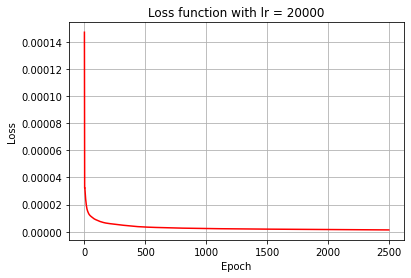

72.62964487075806


In [8]:
import time


start = time.time()
pred = Train_RNN(172, data["Data"].T, data["dt"], mu=data["mu"], n_iters=2500, lr=20000, verbose=True, loss_graph=True)
end = time.time()
print(end-start)

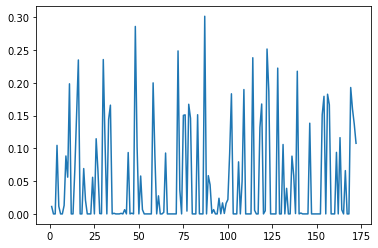

[86, 47]

In [25]:
t = np.linspace(0,150, 4000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

qual = quality(172, train=train, true=true, num_max=2)
qual

We can now plot our **worst** neuron's prediction to get an idea:

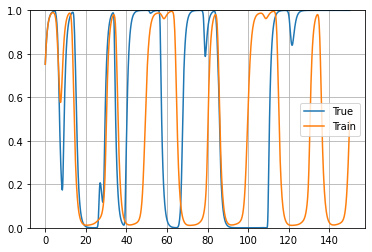

In [27]:
t = np.linspace(0,150, 1000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

plt.plot(t, true[:,86], label="True")
plt.plot(t, train[:,86], label="Train")
plt.grid(True)
plt.legend()
plt.ylim([0, 1])
plt.show()

Without surprise, our worst activity is a chaotic behavior. Also, we can see that the model is quite good between 0 and 100 which is the time in which we train the model. We can look at another example of more complex behavior. Remember that everything after 100 is a prediction.

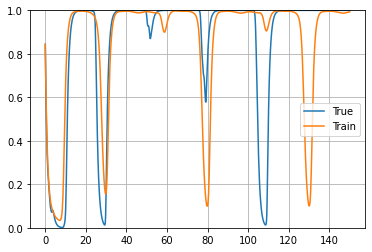

In [32]:
t = np.linspace(0,150, 1000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

plt.plot(t, true[:,88], label="True")
plt.plot(t, train[:,88], label="Train")
plt.grid(True)
plt.legend()
plt.ylim([0, 1])
plt.show()

Actually, most neurons are well model and look like that:

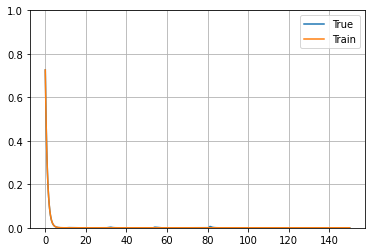

In [37]:
t = np.linspace(0,150, 1000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

plt.plot(t, true[:,22], label="True")
plt.plot(t, train[:,22], label="Train")
plt.grid(True)
plt.legend()
plt.ylim([0, 1])
plt.show()

---------------

Now, let's use $500$ neurons. We will have a chaotic behavior which is quite common with random matrix of this size. Chaotic matrix are hard to modelize because our model must have the exact same weight matrix to perfectly predict what's next

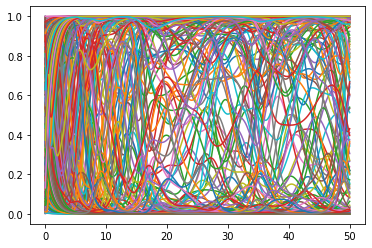

In [38]:
IC = np.random.rand(500)
W = np.random.randn(500, 500)
t = np.linspace(0, 50, 1000)

data = GenerateData(n_data=1500, IC=IC, time=50, W=W, ratio=1)

plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0])
plt.show()

epoch 0/2500 loss 0.000254
epoch 100/2500 loss 0.000009
epoch 200/2500 loss 0.000008
epoch 300/2500 loss 0.000007
epoch 400/2500 loss 0.000007
epoch 500/2500 loss 0.000006
epoch 600/2500 loss 0.000006
epoch 700/2500 loss 0.000005
epoch 800/2500 loss 0.000005
epoch 900/2500 loss 0.000005
epoch 1000/2500 loss 0.000004
epoch 1100/2500 loss 0.000004
epoch 1200/2500 loss 0.000004
epoch 1300/2500 loss 0.000004
epoch 1400/2500 loss 0.000003
epoch 1500/2500 loss 0.000003
epoch 1600/2500 loss 0.000003
epoch 1700/2500 loss 0.000003
epoch 1800/2500 loss 0.000003
epoch 1900/2500 loss 0.000003
epoch 2000/2500 loss 0.000002
epoch 2100/2500 loss 0.000002
epoch 2200/2500 loss 0.000002
epoch 2300/2500 loss 0.000002
epoch 2400/2500 loss 0.000002


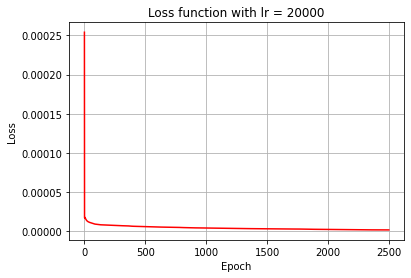

60.38937711715698


In [40]:
import time
start = time.time()
pred = Train_RNN(500, data["Data"].T, data["dt"], mu=data["mu"], n_iters=2500, lr=20000, verbose=True, loss_graph=True)
end = time.time()
print(end-start)

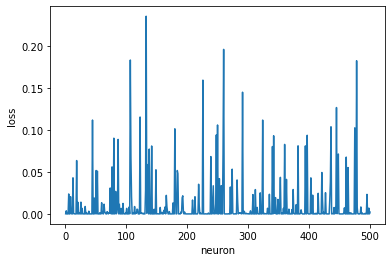

[132, 259, 106]

In [46]:
#Quality for t=100 (model train for t=50)
t = np.linspace(0, 100, 1000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]
qual = quality(500, true=true, train=train, num_max=3)
qual

Here, we see that most neurons are well model except for a few. We can plot the **worst** one, which is the neuron #132

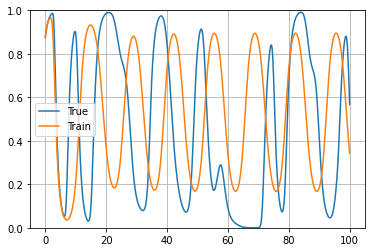

In [47]:
t = np.linspace(0,100, 1000)

plt.plot(t, true[:,132], label="True")
plt.plot(t, train[:,132], label="Train")
plt.grid(True)
plt.legend()
plt.ylim([0, 1])
plt.show()

We can see that the model is not actually that far away from the reality. We have the same "shape" except with a difference in the moment where each shapes is encounter. We can see an example where the train though a neuron was oscillating when she had a chaotic behavior :

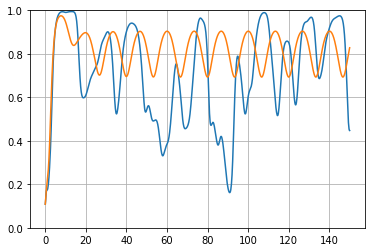

In [54]:
t = np.linspace(0,150, 1000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

plt.plot(t, true[:,12], label="True")
plt.plot(t, train[:,12], label="Train")
plt.grid(True)
plt.ylim([0, 1])
plt.show()

As usual, most neuron converge to a certain value and they are well model:

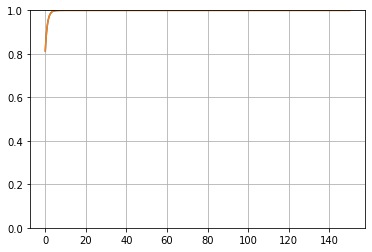

In [56]:
t = np.linspace(0,150, 1000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

plt.plot(t, true[:,322], label="True")
plt.plot(t, train[:,322], label="Train")
plt.grid(True)
plt.ylim([0, 1])
plt.show()

*Remark : the learning rate seems to depend on the number of data we have. If we have a high amount of data, we need a big learning rate and vice-versa. Here, with n_data=100. Here's an example*

In [149]:
IC = np.random.rand(40)
W = 10*np.random.randn(40, 40)

data = GenerateData(n_data=100, time=10, IC=IC, W=W, ratio=1)

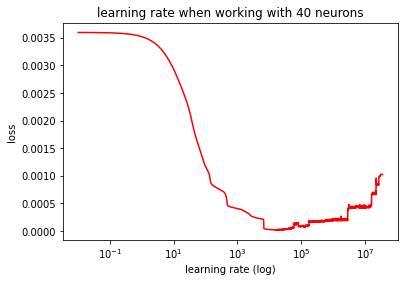

In [181]:
learn = Train_RNN_AdaptLR(40, data["Data"].T, data["dt"], data["mu"], n_iters=4000, loss_graph=True)

We see that $10^3$ is a great learning rate

epoch 0/4000 loss 0.002260
epoch 100/4000 loss 0.000096
epoch 200/4000 loss 0.000035
epoch 300/4000 loss 0.000029
epoch 400/4000 loss 0.000026
epoch 500/4000 loss 0.000023
epoch 600/4000 loss 0.000022
epoch 700/4000 loss 0.000021
epoch 800/4000 loss 0.000020
epoch 900/4000 loss 0.000015
epoch 1000/4000 loss 0.000014
epoch 1100/4000 loss 0.000013
epoch 1200/4000 loss 0.000012
epoch 1300/4000 loss 0.000012
epoch 1400/4000 loss 0.000012
epoch 1500/4000 loss 0.000011
epoch 1600/4000 loss 0.000011
epoch 1700/4000 loss 0.000011
epoch 1800/4000 loss 0.000010
epoch 1900/4000 loss 0.000010
epoch 2000/4000 loss 0.000010
epoch 2100/4000 loss 0.000010
epoch 2200/4000 loss 0.000010
epoch 2300/4000 loss 0.000009
epoch 2400/4000 loss 0.000009
epoch 2500/4000 loss 0.000009
epoch 2600/4000 loss 0.000009
epoch 2700/4000 loss 0.000008
epoch 2800/4000 loss 0.000008
epoch 2900/4000 loss 0.000008
epoch 3000/4000 loss 0.000007
epoch 3100/4000 loss 0.000007
epoch 3200/4000 loss 0.000007
epoch 3300/4000 loss 0

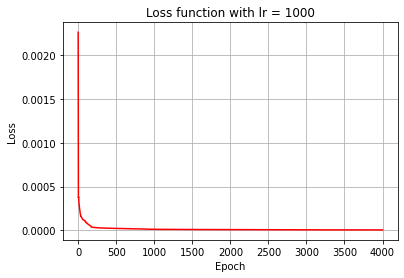

In [182]:
pred = Train_RNN(40, data["Data"].T, data["dt"], mu=data["mu"], lr=10**3, n_iters=4000, verbose=True, loss_graph=True)

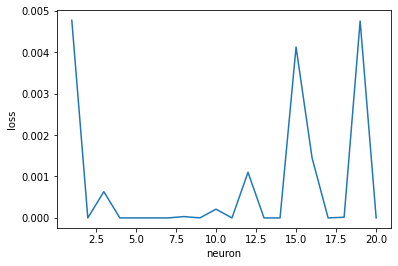

[0, 18, 14]

In [167]:
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

t = np.linspace(0, 30, 1000)

qual = quality(20, true, train, num_max=3)
qual

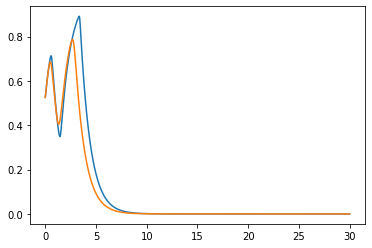

In [169]:
plt.plot(t, true[:,0])
plt.plot(t, train[:,0])
plt.show()

### Using real dataset

Let's use celegans_2019 with male_chemical. We can download the .csv and generate fake data with the matrix that was taken directly from the database. This dataset has 575 neurons. 

In [184]:
import pandas as pd
import numpy as np

data = pd.read_csv("celegans_male_chemical.csv")

W_true = np.zeros((575, 575))

for i in range(575):
    W_true[data.iloc[i,1],data.iloc[i,0]] = data.iloc[i,2]   #iloc -> index


In [205]:
IC = np.random.rand(575)

data = GenerateData(n_data=3000, time=30, IC=IC, W=W_true, ratio=1)

Let's find the best learning rate :

epoch 0/2500 loss 0.000027
epoch 100/2500 loss 0.000027
epoch 200/2500 loss 0.000027
epoch 300/2500 loss 0.000027
epoch 400/2500 loss 0.000027
epoch 500/2500 loss 0.000027
epoch 600/2500 loss 0.000027
epoch 700/2500 loss 0.000027
epoch 800/2500 loss 0.000027
epoch 900/2500 loss 0.000027
epoch 1000/2500 loss 0.000027
epoch 1100/2500 loss 0.000027
epoch 1200/2500 loss 0.000026
epoch 1300/2500 loss 0.000026
epoch 1400/2500 loss 0.000025
epoch 1500/2500 loss 0.000024
epoch 1600/2500 loss 0.000023
epoch 1700/2500 loss 0.000022
epoch 1800/2500 loss 0.000022
epoch 1900/2500 loss 0.000021
epoch 2000/2500 loss 0.000020
epoch 2100/2500 loss 0.000020
epoch 2200/2500 loss 0.000018
epoch 2300/2500 loss 0.000017
epoch 2400/2500 loss 0.000018


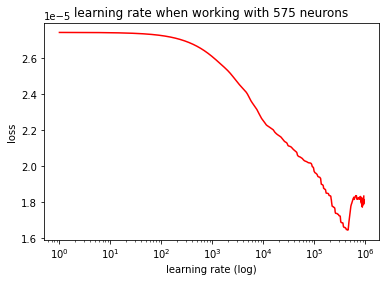

In [206]:
learn = Train_RNN_AdaptLR(575, data["Data"].T, data["dt"], mu=data["mu"], n_iters=2500, loss_graph=True, verbose=True, a=1, b=0.0055)

epoch 0/1000 loss 0.000007
epoch 100/1000 loss 0.000002
epoch 200/1000 loss 0.000001
epoch 300/1000 loss 0.000001
epoch 400/1000 loss 0.000001
epoch 500/1000 loss 0.000000
epoch 600/1000 loss 0.000000
epoch 700/1000 loss 0.000000
epoch 800/1000 loss 0.000000
epoch 900/1000 loss 0.000000


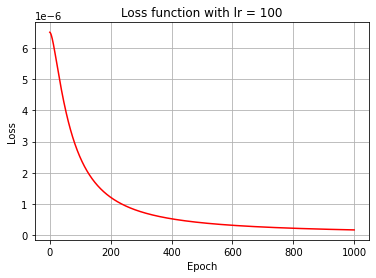

56.71221590042114


In [237]:
import time
start = time.time()
pred = Train_RNN(575, data["Data"].T, data["dt"], data["mu"], lr=10**2, n_iters=1000, verbose=True, loss_graph=True)
end = time.time()
print(end-start)

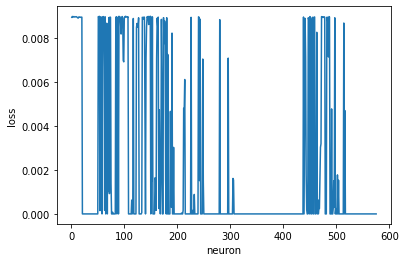

[148, 89, 52, 101, 144]

In [238]:
t = np.linspace(0,60,2000)

true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

qual = quality(575, true, train, 5)
qual

We can plot our *worst* neuron. The other neuron are really close to one another.

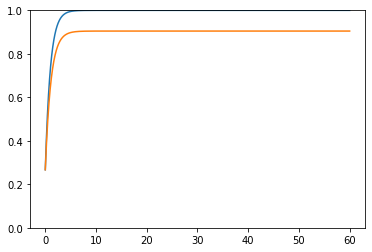

In [239]:
plt.plot(t, true[:,148])
plt.plot(t, train[:,148])
plt.ylim([0,1])
plt.show()

In fact, here's the complete model :

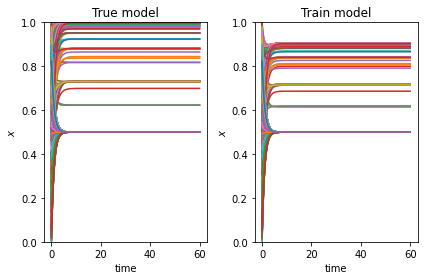

In [240]:
plt.figure(1)

plt.subplot(121)
plt.plot(t, true)
plt.xlabel("time")
plt.ylabel(r"$x$")
plt.title("True model")
plt.ylim([0,1])
plt.tight_layout()

plt.subplot(122)
plt.plot(t, train)
plt.xlabel("time")
plt.ylabel(r"$x$")
plt.title("Train model")
plt.ylim([0,1])
plt.tight_layout()

plt.show()

------------------
**Hermaphrodite chemical synapse**

In [9]:
import pandas as pd
import numpy as np

data = pd.read_csv("hermaphrodite_chemical_synapse.csv")

W_true = np.zeros((468, 468))

for i in range(468):
    W_true[data.iloc[i,1],data.iloc[i,0]] = data.iloc[i,2]   #iloc -> index

In [10]:
IC = np.random.rand(468)
data = GenerateData(n_data=2500, time=50, IC=IC, W=W_true, ratio=1)

epoch 0/2500 loss 0.000104
epoch 100/2500 loss 0.000104
epoch 200/2500 loss 0.000104
epoch 300/2500 loss 0.000104
epoch 400/2500 loss 0.000104
epoch 500/2500 loss 0.000104
epoch 600/2500 loss 0.000104
epoch 700/2500 loss 0.000104
epoch 800/2500 loss 0.000103
epoch 900/2500 loss 0.000102
epoch 1000/2500 loss 0.000100
epoch 1100/2500 loss 0.000098
epoch 1200/2500 loss 0.000095
epoch 1300/2500 loss 0.000092
epoch 1400/2500 loss 0.000087
epoch 1500/2500 loss 0.000082
epoch 1600/2500 loss 0.000079
epoch 1700/2500 loss 0.000075
epoch 1800/2500 loss 0.000071
epoch 1900/2500 loss 0.000067
epoch 2000/2500 loss 0.000064
epoch 2100/2500 loss 0.000062
epoch 2200/2500 loss 0.000070
epoch 2300/2500 loss 0.000076
epoch 2400/2500 loss 0.000087


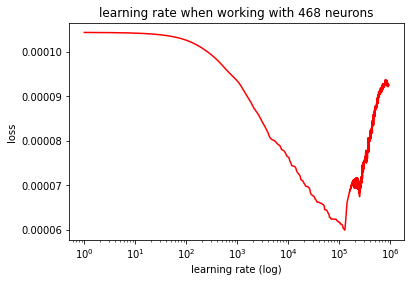

In [11]:
learn = Train_RNN_AdaptLR(468, data["Data"].T, data["dt"], mu=data["mu"], n_iters=2500, verbose=True, loss_graph=True, a=1, b=0.0055)

epoch 0/1000 loss 0.000019
epoch 100/1000 loss 0.000000
epoch 200/1000 loss 0.000000
epoch 300/1000 loss 0.000000
epoch 400/1000 loss 0.000000
epoch 500/1000 loss 0.000000
epoch 600/1000 loss 0.000000
epoch 700/1000 loss 0.000000
epoch 800/1000 loss 0.000000
epoch 900/1000 loss 0.000000


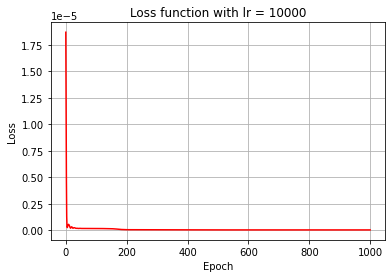

In [12]:
import time
start = time.time()
pred = Train_RNN(468, data["Data"].T, data["dt"], data["mu"], lr=10**4, n_iters=1000, verbose=True, loss_graph=True)

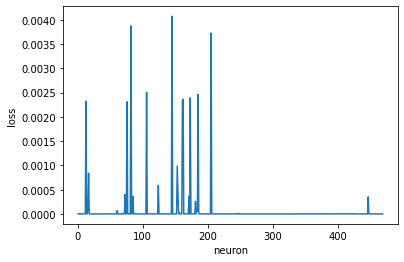

[144, 81, 204, 105, 184]

In [14]:
t = np.linspace(0,100,2000)

true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

qual = quality(468, true, train, 5)
qual

We can analyse our *worst* neuron :

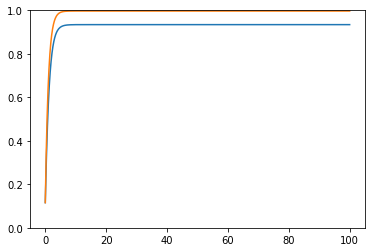

In [17]:
plt.plot(t, true[:,144])
plt.plot(t, train[:,144])
plt.ylim([0,1])
plt.show()

As usual, most of our neurons are almost perfect. We can plot our two models side by side to compare. We can see that a few neurons are a little bit off.

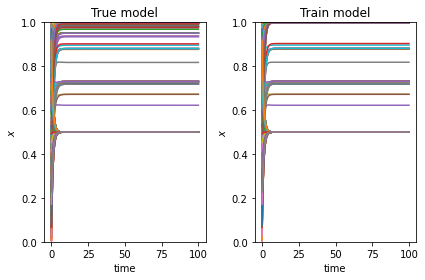

In [18]:
plt.figure(1)

plt.subplot(121)
plt.plot(t, true)
plt.xlabel("time")
plt.ylabel(r"$x$")
plt.title("True model")
plt.ylim([0,1])
plt.tight_layout()

plt.subplot(122)
plt.plot(t, train)
plt.xlabel("time")
plt.ylabel(r"$x$")
plt.title("Train model")
plt.ylim([0,1])
plt.tight_layout()

plt.show()

---------------------------
**Cintestinalis**

205 nodes

In [21]:
import pandas as pd
import numpy as np

data = pd.read_csv("celegansneural.csv")

W_true = np.zeros((205, 205))

for i in range(205):
    W_true[data.iloc[i,1],data.iloc[i,0]] = data.iloc[i,2]   #iloc -> index


In [22]:
IC = np.random.rand(205)

data = GenerateData(n_data=1500, time=30, IC=IC, W=W_true, ratio=1)

epoch 0/2500 loss 0.000089
epoch 100/2500 loss 0.000089
epoch 200/2500 loss 0.000089
epoch 300/2500 loss 0.000089
epoch 400/2500 loss 0.000089
epoch 500/2500 loss 0.000089
epoch 600/2500 loss 0.000089
epoch 700/2500 loss 0.000088
epoch 800/2500 loss 0.000088
epoch 900/2500 loss 0.000087
epoch 1000/2500 loss 0.000085
epoch 1100/2500 loss 0.000082
epoch 1200/2500 loss 0.000078
epoch 1300/2500 loss 0.000073
epoch 1400/2500 loss 0.000066
epoch 1500/2500 loss 0.000055
epoch 1600/2500 loss 0.000050
epoch 1700/2500 loss 0.000046
epoch 1800/2500 loss 0.000041
epoch 1900/2500 loss 0.000038
epoch 2000/2500 loss 0.000033
epoch 2100/2500 loss 0.000030
epoch 2200/2500 loss 0.000040
epoch 2300/2500 loss 0.000048
epoch 2400/2500 loss 0.000069


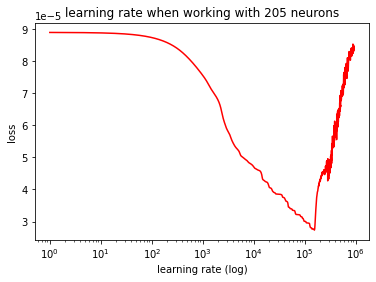

In [28]:
learn = Train_RNN_AdaptLR(205, data["Data"].T, data["dt"], mu=data["mu"], n_iters=2500, loss_graph=True, verbose=True, a=1, b=0.0055)

epoch 0/1000 loss 0.000008 pVar 0.995
epoch 100/1000 loss 0.000000 pVar 1.000
epoch 200/1000 loss 0.000000 pVar 1.000
epoch 300/1000 loss 0.000000 pVar 1.000
epoch 400/1000 loss 0.000000 pVar 1.000
epoch 500/1000 loss 0.000000 pVar 1.000
epoch 600/1000 loss 0.000000 pVar 1.000
epoch 700/1000 loss 0.000000 pVar 1.000
epoch 800/1000 loss 0.000000 pVar 1.000
epoch 900/1000 loss 0.000000 pVar 1.000


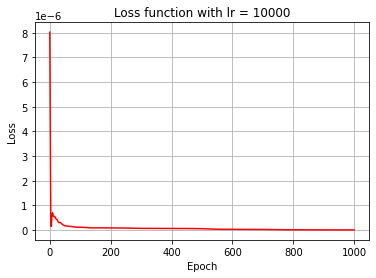

7.34041953086853


In [43]:
import time
start = time.time()
pred = Train_RNN(205, data["Data"].T, data["dt"], data["mu"], lr=10**4, n_iters=1000, verbose=True, loss_graph=True)
end = time.time()
print(end-start)

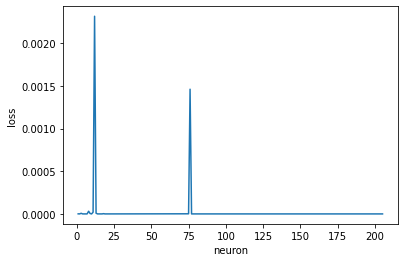

[11, 75, 7, 10, 12]

In [30]:
t = np.linspace(0, 60, 2000)

true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

qual = quality(205, true, train, 5)
qual

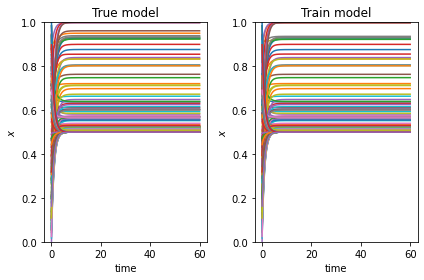

In [34]:
plt.figure(1)

plt.subplot(121)
plt.plot(t, true)
plt.xlabel("time")
plt.ylabel(r"$x$")
plt.title("True model")
plt.ylim([0,1])
plt.tight_layout()

plt.subplot(122)
plt.plot(t, train)
plt.xlabel("time")
plt.ylabel(r"$x$")
plt.title("Train model")
plt.ylim([0,1])
plt.tight_layout()

plt.show()

As usual, we can look at our worst neuron

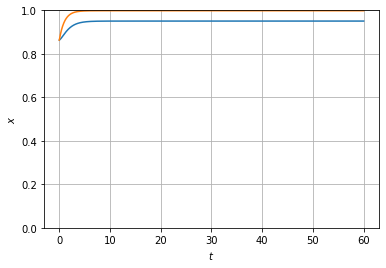

In [37]:
plt.plot(t, true[:,11], label="True")
plt.plot(t, train[:,11], label="Train")
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.ylim([0,1])
plt.grid(True)
plt.show()

--------------------